# RTI Data Science Exercise: Predicting Census Respondent's Income Category

For this exercise census data was collected containing various pieces of information about each respondent, including whether or not they currently make over or under \$50,0000 of income. Moving forward, I will describe this true or false outcome (Making over \$50K, or not, respectively) as the respondent's Income Category.

The data was provided in a normalized SQLite database and was extracted using the sqlite3 Python library. The extracted, denormalized data was then locally stored as a csv for further analysis. This output csv ('flattened_census_data.csv') will be referenced below.

## The Data

The first step in any model building process is data exploration. One of the first things we need to do is examine the distributions and frequencies for each independent variable within the data to get an idea of how good a predictor it might be for helping us predict a respondent's income category. The following were what I found to be the key independent variables in the dataset at our disposal for building a prediction model.
 - Respondent's Age
 - Respondent's Capital Gain Amount
 - Respondent's Education Level
 - Respondent's Hours Worked per Week
 - Respondent's Marital Status
 - Respondent's Occupation
 - Respondent's Race
 - Respondent's Sex

Let's walk through the data exploration process below to demonstrate the ability the above metrics may have in predicting a respondent's Income Category. We will start by loading the denormalized data and summarizing how likely a respondent is to make over $50k in general.

In [3]:
import pandas as pd, numpy as np

#Import flattened CSV census data into dataframe
df = pd.read_csv('../output/flattened_census_data.csv')

#Function to convert target from numeric to boolean
def cat_target(row):
    if row['over_50k'] == 0: #Less than $50k
        return False
    elif row['over_50k'] == 1: #Greater than $50k
        return True 
    else:
        return np.NaN
    
#Create categorical version of target variable
df['over_50_bool'] = df.apply(cat_target, axis=1)

#Print prevalance of respondents earning more than $50k a year
df['over_50_bool'].value_counts(normalize=True)

False    0.760718
True     0.239282
Name: over_50_bool, dtype: float64

We can see from the output above that, overall, a respondent is approximately 24% likely to have an income that is higher than \$50k per year. Now that we know this, we can observe via how the independent variables above may help provide us further information in a respondent's likelihood to make over \$50k.

Text(0.5,1,'% Frequencies by Income Category for Categorical Variables')

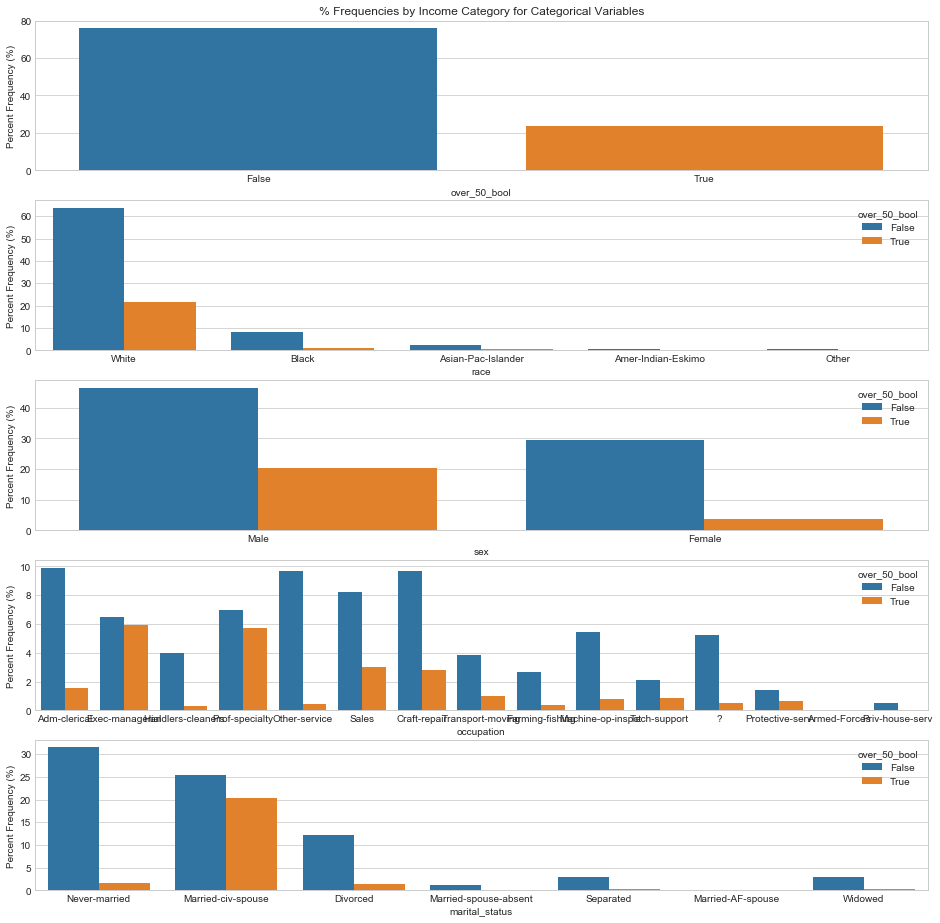

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#Store the independent variables we're interested in a list for looping
#through chart generation
cat_vars = ['race','sex','occupation','marital_status']

#Display by category the likelihood of a respondent earning over 50k
i=1
f, ax = plt.subplots(5,figsize=(16,16))

#Plot overall frequencies for Income Category
sns.barplot(x='over_50_bool', y="respondent_id", data=df, estimator=lambda x: len(x) / len(df) * 100,ax=ax[0])
ax[0].set(ylabel="Percent Frequency (%)")

#Plot % frequencies for categorical variables
for cat_var in cat_vars:
    sns.barplot(x=cat_var, y="respondent_id", data=df, estimator=lambda x: len(x) / len(df) * 100,ax=ax[i],hue="over_50_bool")
    ax[i].set(ylabel="Percent Frequency (%)")
    i+=1
ax[0].set_title("% Frequencies by Income Category for Categorical Variables")


We can also create similar charts for the numeric variables I believed were useful.

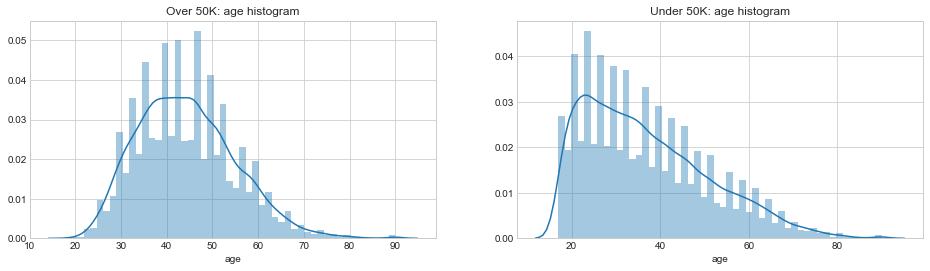

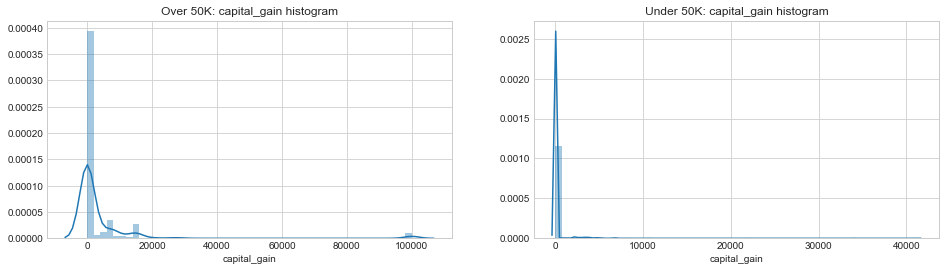

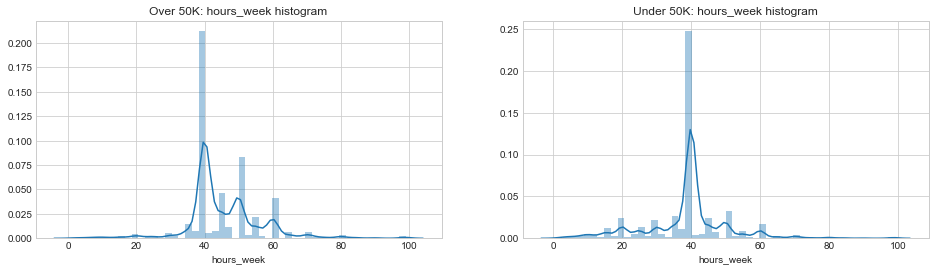

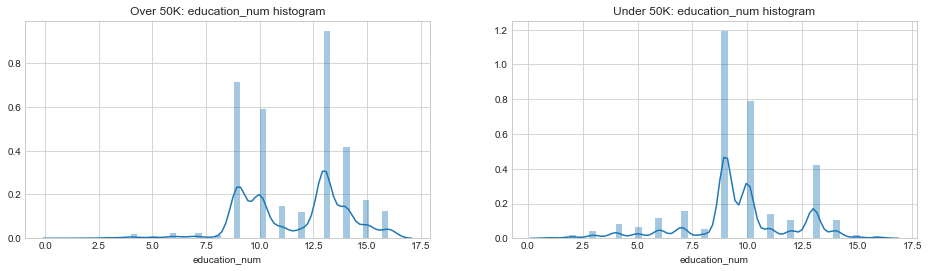

In [41]:
#Store the independent variables we're interested in a list for looping
#through chart generation
numeric_vars = ['age','capital_gain','hours_week','education_num']

#Plot distributions for the numeric vars based on the Income Category
for numeric_var in numeric_vars:
    f, ax = plt.subplots(figsize=(16,4),ncols=2)
    over50=df[df.over_50_bool == True]
    under50=df[df.over_50_bool == False]
    ax[0].title.set_text('Over 50K: ' + numeric_var+' histogram')
    sns.distplot(over50[numeric_var],norm_hist=True,ax=ax[0])
    ax[1].title.set_text('Under 50K: ' + numeric_var+' histogram')
    sns.distplot(under50[numeric_var],norm_hist=True,ax=ax[1])

By looking at the charts for the above categories, we can see the following:
 - The age data is right skewed when looking at respondents who make under \$50k compared to those who make over \$50k. This indicates the distributions are different based on the income category.
 - For respondents who make under \$50k, almost all of the data is concentrated at the 0 value. Whereas respondents who make over \$50k are more likely to see values beyond 0 capital gains.
 - For respondents who make over \$50k, they are more likely to work over 40 hours a week than respondents who make less than \$50k.
 - For respondents who make over \$50k, they are more likely to have higher education levels (> 12) than respondents who make less than \$50k
 
 To capitalize on the above findings, I created 4 new categorical variables to capture the findings.

Text(0.5,1,'% Frequencies by Income Category for Categorical Variables')

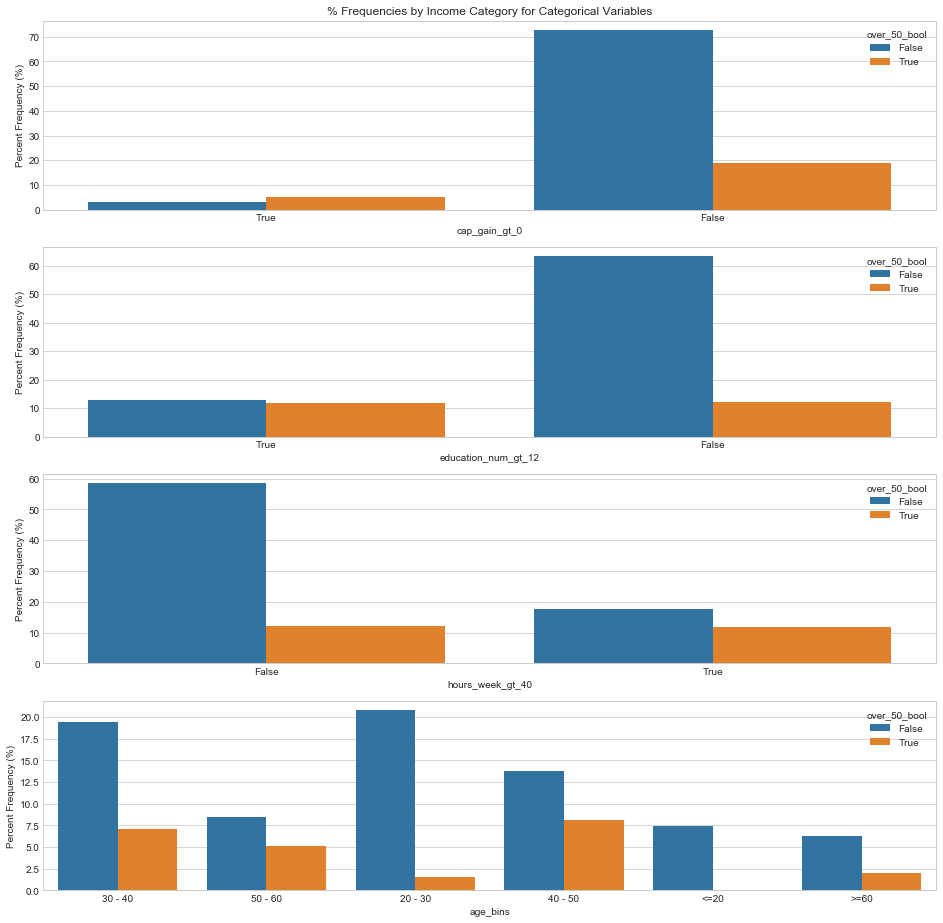

In [46]:
#Function to convert variable into a boolean (string)
def bool_my_feature(row,in_var,threshold):
    if row[in_var] > threshold:
        return 'True'
    elif row[in_var] <= threshold:
        return 'False' 
    else:
        return np.NaN

#Function to categorize numeric variable into bins
def bin_my_feature(row,in_var,bin_list):
    bin_list.sort() #Just in case
    out_label = np.NaN #If field doesn't match any bins
    n = len(bin_list)-1 #Max index
    for i in list(range(0,n+1)):
        if i < n:
            #Lower and upper ends of bin
            x,y = bin_list[i:i+2] 
        if i == 0 and row[in_var] <= bin_list[i]:
            #Value is less than min bin value
            out_label = '<=' + str(bin_list[i])
        elif i == n and row[in_var] >= bin_list[i]:
            #Value is greater than max bin value
            out_label = '>=' + str(bin_list[i])
        elif i < n and row[in_var] >= x and row[in_var] < y:
            out_label = str(x) + ' - ' + str(y)
    return out_label

#Create categorical versions of numeric independent variables
df['cap_gain_gt_0'] = df.apply(bool_my_feature, args=('capital_gain',0),axis=1)
df['education_num_gt_12'] = df.apply(bool_my_feature, args=('education_num',12),axis=1)
df['hours_week_gt_40'] = df.apply(bool_my_feature, args=('hours_week',40),axis=1)
df['age_bins'] = df.apply(bin_my_feature, args=('age',[20,30,40,50,60]),axis=1)

#Prepare variables for displaying newly created features
new_cat_features = ['cap_gain_gt_0','education_num_gt_12','hours_week_gt_40','age_bins']
i=0
f, ax = plt.subplots(4,figsize=(16,16))

#Generate plots for new features to assess information gain
for cat_var in new_cat_features:
    sns.barplot(x=cat_var, y="respondent_id", data=df, estimator=lambda x: len(x) / len(df) * 100,ax=ax[i],hue="over_50_bool")
    ax[i].set(ylabel="Percent Frequency (%)")
    i+=1
ax[0].set_title("% Frequencies by Income Category for Categorical Variables")

By observing the above charts we can see there are a lot of segments where the likelihood for making over \$50k vary considerably from the overall average likelihood. This helps provide us information such that, given a specific event or condition occuring (e.g. a respondent has been never married, a respondent is black, a respondent has capital gains > 0 etc.), we know that this respondent is more or less likely to make \$50k per year than if we were to guess based off the overall average likelihood. 

Using these conditional probabilities, we can build a Naive Bayes model for predicting the class of a respondent's income category (Over or Under \$50k).

## The Model
In order to train the Naive Bayes model, we first need to divide up our dataset into a training segment and testing segment (foregoing validation segment in this case as I have already arrived at final model). Once we have the training dataset, we will need to use this to create the conditional probabilities necessary for predicting a respondent's income category.

In [55]:
#Weights for Training and Test Datasets
train_weight = 0.8
test_weight = 0.2

#Sample records for test dataset 
test_bool = np.random.rand(len(df)) < test_weight
test = df[test_bool]

#Of remaining records not in test, sample for training
train = df[~test_bool]

#Print out sample counts
print(str(len(train)) + ' records for training model')
print(str(len(test)) + ' records for testing model')

39099 records for training model
9743 records for testing model


Given that we now have separated the training and test data, we can start building the conditional probabilities necessary from the training data to score the testing data.

In [56]:
#Define final variables to be used in the model building process
#The below list indicates the variable name and field label to be
#assigned to it.
model_features = [('age_bins','age'),('education_num_gt_12','ed_lvl'), \
    ('hours_week_gt_40','hr_per_week'), ('cap_gain_gt_0','cap_gain'), \
    ('sex','sex'), ('race','race'),('occupation','occup'), \
    ('marital_status','MS')]

def create_cond_probs(train,test,x):
    variable,label = x
    cond_probs = pd.crosstab(train[variable],train.over_50_bool).apply(lambda r: r/r.sum(),axis=0)
    cond_probs.columns = ['P('+label+'|False)','P('+label+'|True)']
    new_test = test.merge(right=cond_probs,how='inner',left_on=variable,right_index=True,sort=False)
    return new_test

#Assign conditional probabilities to validation data
for var, label in model_features:
    x = (var,label)
    test = create_cond_probs(train,test,x)

#Create percent frequencies for either target class
target_probs = test['over_50_bool'].value_counts(normalize=True).to_dict()

#Add likelihoods for each income category to dataframe
test['True_Likelihood'] = target_probs[True]
test['False_Likelihood'] = target_probs[False]

#Extract conditional probabilities and target likelihoods by target
#for multiplying into each other
under50_cols = [col for col in test.columns if 'False' in col]
over50_cols = [col for col in test.columns if 'True' in col]
test['Under50_Score'] = 1
test['Over50_Score'] = 1

# Multiply conditional probabilities under assumption
# respondent makes less than 50k
for col in under50_cols:
    test['Under50_Score'] = test['Under50_Score'].multiply(test[col],axis=0)

# Multiply conditional probabilities under assumption
# respondent makes over than 50k
for col in over50_cols:
    test['Over50_Score'] = test['Over50_Score'].multiply(test[col],axis=0)

#Get predictions based on final target scores
def get_pred(row):
    if row['Under50_Score'] > row['Over50_Score']:
        return False
    else:
        return True

#Compare predictions to actual target test_dataues
def assess_accuracy(row):
    if row['pred'] == row['over_50_bool']:
        return 'Accurate'
    else:
        return 'Inaccurate'

#Assign a prediction based on training data
test['pred'] = test.apply(get_pred,axis=1)

#Evaluate if prediction was accurate or not
test['accurate'] = test.apply(assess_accuracy,axis=1)

#Print out accuracy on test data
print('Model accuracy for Testing set (' + str(len(test)) + " records):")
print(test['accurate'].value_counts(normalize=True))

Model accuracy for Test set (9743 records):
Accurate      0.82336
Inaccurate    0.17664
Name: accurate, dtype: float64


## Conclusion
Based on the above Naive Bayes model with selected features (independent variables), we are able to achieve approximately an 82% success rate in predicting whether a respondent makes more or less than \$50k per year. If we compare this to the general likelihood based on the overall frequencies for over \$50k (24%) and under \$50k (76%), we may expect this model to provide an additional 6 percentage points of accuracy (for this sample set) as opposed to making the crude assumption that all respondent's make less than \$50k per year.